In [23]:
import torch
import deep.model as models
import deep.training as training
import pandas as pd
from tool.preprocessing import DataCollection
from tool.create_dataset import creation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [24]:
#Hyperparameters
NUM_RECORD = 12
TOTAL_DIMENSION = NUM_RECORD*6
PROB = 1
BATCH_SIZE=128
NUM_HIDDEN = 748
LR=1e-4
NUM_EPOCHS = 200

#Data Loader
collection = DataCollection(drop_null=True)
gt = collection.get_gt()

X = torch.tensor([]).to(torch.device("cuda:0"))
y = torch.tensor([]).to(torch.device("cuda:0"))
for i in collection.get_devices():
    tmp = pd.merge(i,gt,how="inner",on="valid_at").rename(columns={"pm2p5_y":"pm2p5_t","pm2p5_x":"pm2p5"})
    res = creation(tmp,lookback=NUM_RECORD,p=1)
    X = torch.concat([X.clone(),res[0].flatten(-2)])
    y = torch.concat((y.clone(),res[1].flatten(-2)[:,0]))

#### normalization

In [25]:
from sklearn.preprocessing import normalize


X_norm = torch.tensor(normalize(X.cpu(),axis=0)).to(torch.device("cuda:0")).float()



In [26]:
import torch.nn as nn
def eval(mlp: nn.Module, data_loader: torch.utils.data.DataLoader, 
             device: torch.device):
  
  loss_fun = nn.L1Loss().to(device)
  correct = 0
  total = 0
  
  with torch.no_grad():
    for x, y in data_loader:
     
      x, y = x.to(device), y.to(device)
      y_pred = mlp(x)
      #print(y_pred.shape,y.shape)
      mean = loss_fun(y_pred,y)
      #print(mean)
      correct+=mean
      
      total+=1
  return correct/total

In [27]:
X_norm

tensor([[0.0051, 0.0026, 0.0065,  ..., 0.0176, 0.0094, 0.0006],
        [0.0051, 0.0026, 0.0065,  ..., 0.0153, 0.0000, 0.0006],
        [0.0056, 0.0023, 0.0065,  ..., 0.0153, 0.0000, 0.0008],
        ...,
        [0.0087, 0.0017, 0.0064,  ..., 0.0029, 0.0097, 0.0360],
        [0.0088, 0.0014, 0.0064,  ..., 0.0029, 0.0097, 0.0411],
        [0.0088, 0.0013, 0.0064,  ..., 0.0029, 0.0097, 0.0497]],
       device='cuda:0')

In [28]:
X.shape


torch.Size([24381, 72])

Epoch   0 train mse.: 11.842 test mse.: 11.576 || R-2 on test: -0.345
Epoch   2 train mse.: 8.719 test mse.: 8.586 || R-2 on test: 0.263
Epoch   4 train mse.: 6.374 test mse.: 6.295 || R-2 on test: 0.584
Epoch   6 train mse.: 5.775 test mse.: 5.855 || R-2 on test: 0.648
Epoch   8 train mse.: 5.517 test mse.: 5.627 || R-2 on test: 0.669
Epoch  10 train mse.: 5.294 test mse.: 5.417 || R-2 on test: 0.690
Epoch  12 train mse.: 5.194 test mse.: 5.369 || R-2 on test: 0.695
Epoch  14 train mse.: 5.169 test mse.: 5.371 || R-2 on test: 0.696
Epoch  16 train mse.: 5.083 test mse.: 5.279 || R-2 on test: 0.699
Epoch  18 train mse.: 5.023 test mse.: 5.351 || R-2 on test: 0.700
Epoch  20 train mse.: 5.314 test mse.: 5.473 || R-2 on test: 0.681
Epoch  22 train mse.: 4.806 test mse.: 5.096 || R-2 on test: 0.718
Epoch  24 train mse.: 5.162 test mse.: 5.404 || R-2 on test: 0.683
Epoch  26 train mse.: 5.026 test mse.: 5.442 || R-2 on test: 0.696
Epoch  28 train mse.: 4.510 test mse.: 4.923 || R-2 on test

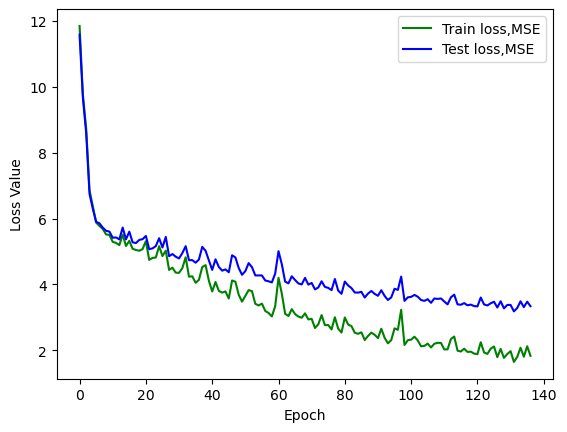

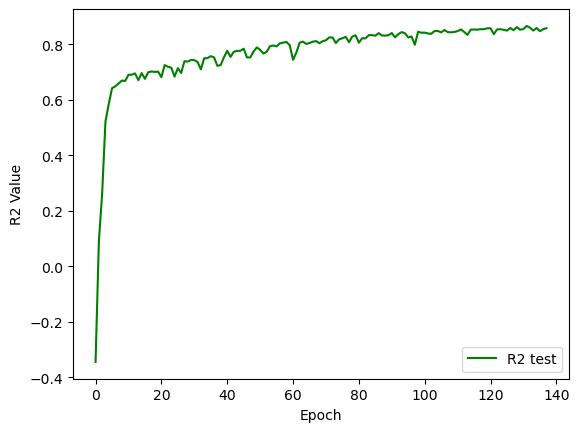

In [29]:
import torch
import numpy as np
import torch.nn as nn

import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import r2_score




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Training
model = models.AirMLP_6(num_fin=TOTAL_DIMENSION,num_hidden=NUM_HIDDEN).to(device)
loss_fn = nn.L1Loss().to(device)
optimizer = optim.RAdam(model.parameters(), lr=LR)
loss_eval = nn.L1Loss().to(device)
X_train, X_test, y_train, y_test = train_test_split(X_norm,y,test_size=0.25)
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
loader_test = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=BATCH_SIZE)

tr_loss = list()
ts_loss = list()
r2test = list()
try:
    for epoch in range(NUM_EPOCHS):
        
        model.train()
        for X_batch, y_batch in loader:
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        model.eval()
        
        pred_train = model(X_train)
        pred_test = model(X_test)
        tr = loss_eval(pred_train,y_train)
        ts = loss_eval(pred_test,y_test)

        tr_loss.append(tr.cpu().detach().numpy())
        ts_loss.append(ts.cpu().detach().numpy())
        r2_test = r2_score(y_test.cpu().detach().numpy(),pred_test.cpu().detach().numpy())
        r2test.append(r2_test)
        # Validation
        if epoch % 2 != 0:
            continue
        
        print(f"Epoch {epoch:3d} train mse.: {tr:.3f} test mse.: {ts:.3f} || R-2 on test: {r2_test:.3f}")
except KeyboardInterrupt:
    model.eval()
    pred_train = model(X_train)
    pred_test = model(X_test)
    tr_lss = loss_eval(pred_train,y_train)
    ts_lss = loss_eval(pred_test,y_test)
    r2_test = r2_score(y_test.cpu().detach().numpy(),pred_test.cpu().detach().numpy())
    r2test.append(r2_test)
    print(f"Epoch {epoch:3d} train mse.: {tr_lss:.3f} test mse.: {ts_lss:.3f} || R-2 on test: {r2_test:.3f}")
    NUM_EPOCHS_DONE = epoch
    

plt.plot(tr_loss,'-g', label="Train loss,MSE")
plt.plot(ts_loss,'-b', label="Test loss,MSE")
leg = plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.show()

plt.plot(r2test,'-g', label="R2 test")
plt.xlabel("Epoch")
plt.ylabel("R2 Value")
leg = plt.legend(loc='lower right')
plt.show()

In [ ]:
PATH_MODEL = r'.\results\weights\weights_mlp_20230420_with-norm-byhand_6.pth'

In [ ]:
torch.save(model,PATH_MODEL)

In [ ]:
model_rest = models.AirMLP_6(num_fin=TOTAL_DIMENSION,num_hidden=NUM_HIDDEN).to(device)
model_rest = torch.load(PATH_MODEL)
model_rest.eval()

AirMLP_8_noNorm(
  (net): Sequential(
    (0): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=72, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
from pyts.metrics import dtw